<a href="https://colab.research.google.com/github/sheelaj123/Explainable-AI--Demos/blob/main/Explainable_AI_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demonstration of  building an explainable AI with linear regression using Shapely library in Python :-

##Shapely:

1. Shapely is a Python package used to perform geometry operations in Python.
2. It is used in Spatial data Analysis
3. The fundamental types of geometric objects implemented by Shapely are points, curves, and surfaces.
   Shapely installation command:  



In [1]:
!pip install shapely

Below code demonstrates on how to create line and polygon using shapely:

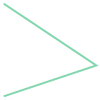

In [2]:
from shapely.geometry import Point, LineString
# Create a LineString from coordinate sets
line = LineString([(0, 0), (3, 1), (0, 3)])
line


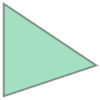

In [3]:
from shapely.geometry import Polygon
polygon = Polygon([(0, 0), (3, 1), (0, 3)])
polygon


#Explainable Clustering using CNN :

In [4]:
!pip install shap

In [5]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


#1. Train the CNN

In [6]:
# Download the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# Reshape and normalize data
x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255


For the CNN model you will use a simple architecture composed of a single convolutional and max pooling layers pair connected to a fully connected layer with 256 units and the output layer with 10 units since there are 10 categories.

In [7]:
# Define the model architecture using the functional API
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)
# Create the model with the corresponding inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")
# Compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )
# Train it!
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))


Epoch 1/5
1875/1875 [==============================] - 86s 46ms/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.3176 - val_sparse_categorical_accuracy: 0.8857
Epoch 2/5
1875/1875 [==============================] - 57s 30ms/step - loss: 0.2538 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.2587 - val_sparse_categorical_accuracy: 0.9069
Epoch 3/5
1875/1875 [==============================] - 57s 31ms/step - loss: 0.2071 - sparse_categorical_accuracy: 0.9248 - val_loss: 0.2833 - val_sparse_categorical_accuracy: 0.9025
Epoch 4/5
1875/1875 [==============================] - 59s 31ms/step - loss: 0.1732 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.2586 - val_sparse_categorical_accuracy: 0.9103
Epoch 5/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.2581 - val_sparse_categorical_accuracy: 0.9126


#Explaining the outputs


You are aware that the model accurately classifies about 90% of the test set's photos. How, though, is it succeeding? What pixels are being used to categorise images into different classes?

You can use SHAP values to respond to these queries.

Check the appearance of each category before proceeding:

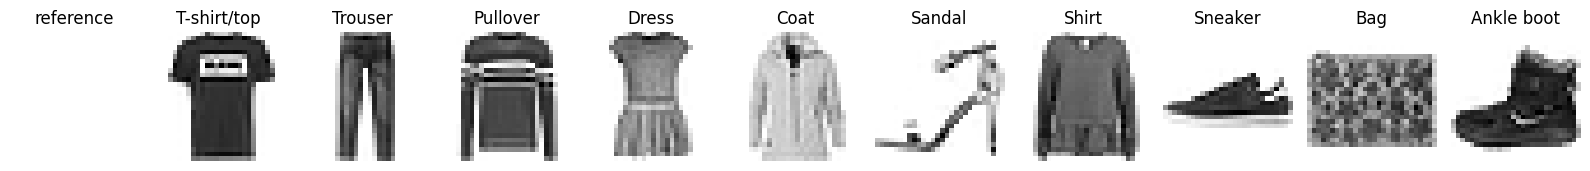

In [8]:
# Name each one of the classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
    if len(images_dict) == 10:
        break
    if l not in images_dict.keys():
        images_dict[l] = x_train[i].reshape((28, 28))

# Function to plot images
def plot_categories(images):
    fig, axes = plt.subplots(1, 11, figsize=(16, 15))
    axes = axes.flatten()

    # Plot an empty canvas
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')

    # Plot an image for every category
    for k, v in images.items():
        ax = axes[k + 1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"{class_names[k]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Use the function to plot
plot_categories(images_dict)

#DeepExplainer
The DeepExplainer class from the shap library will be used to calculate shap values for the model you just trained.

You must provide in a model and training examples in order to instantiate this class. Observe that only a portion of the training examples are passed in rather than all of them.

This is done because the DeepExplainer object uses a lot of RAM during computations and you might run out of memory.



In [9]:
# Take a random sample of 5000 training images
background = x_train[np.random.choice(x_train.shape[0], 5000, replace=False)]
# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)
# Compute shap values
# shap_values = e.shap_values(x_test[1:5])


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


###Now you can compute Shap values for the photos in the test set using the DeepExplainer instance.

Make an array with one member for each class from the test set so you can appropriately visualise these values for each class:

In [10]:
# Assuming y_test is the labels for the test set and x_test is the corresponding data
x_test_dict = dict()

# Iterate over the test set
for i, label in enumerate(y_test):
    # If we've collected an example for each of 10 classes, break the loop
    if len(x_test_dict) == 10:
        break

    # If this label is not yet in the dictionary, add it
    if label not in x_test_dict.keys():
        x_test_dict[label] = x_test[i]

# Create a list of examples, each representing one class, preserving the order of classes
x_test_each_class = [x_test_dict[label] for label in sorted(x_test_dict)]

# Convert the list to a NumPy array
x_test_each_class = np.asarray(x_test_each_class)

# Print the shape of the tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

x_test_each_class tensor has shape: (10, 28, 28, 1)


In [11]:
# Compute predictions
predictions = model.predict(x_test_each_class)
# Apply argmax to get predicted class
np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 98ms/step


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#Visualizing Shap Values
Now that you have an example of each class, compute the Shap values for each example:

In [12]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


###Now take a look at the computed shap values. To understand the next illustration have these points in mind:

Positive shap values are denoted by red color and they represent the pixels that contributed to classifying that image as that particular class.
Negative shap values are denoted by blue color and they represent the pixels that contributed to NOT classify that image as that particular class.
Each row contains each one of the test images you computed the shap values for.
Each column represents the ordered categories that the model could choose from. Notice that shap.image_plot just makes a copy of the classified image, but you can use the plot_categories function you created earlier to show an example of that class for reference

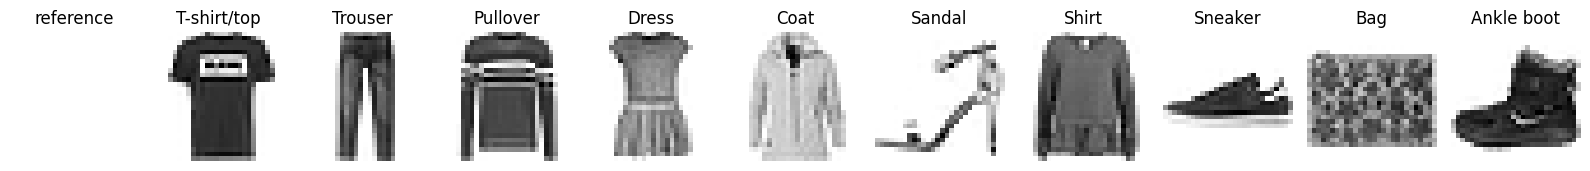

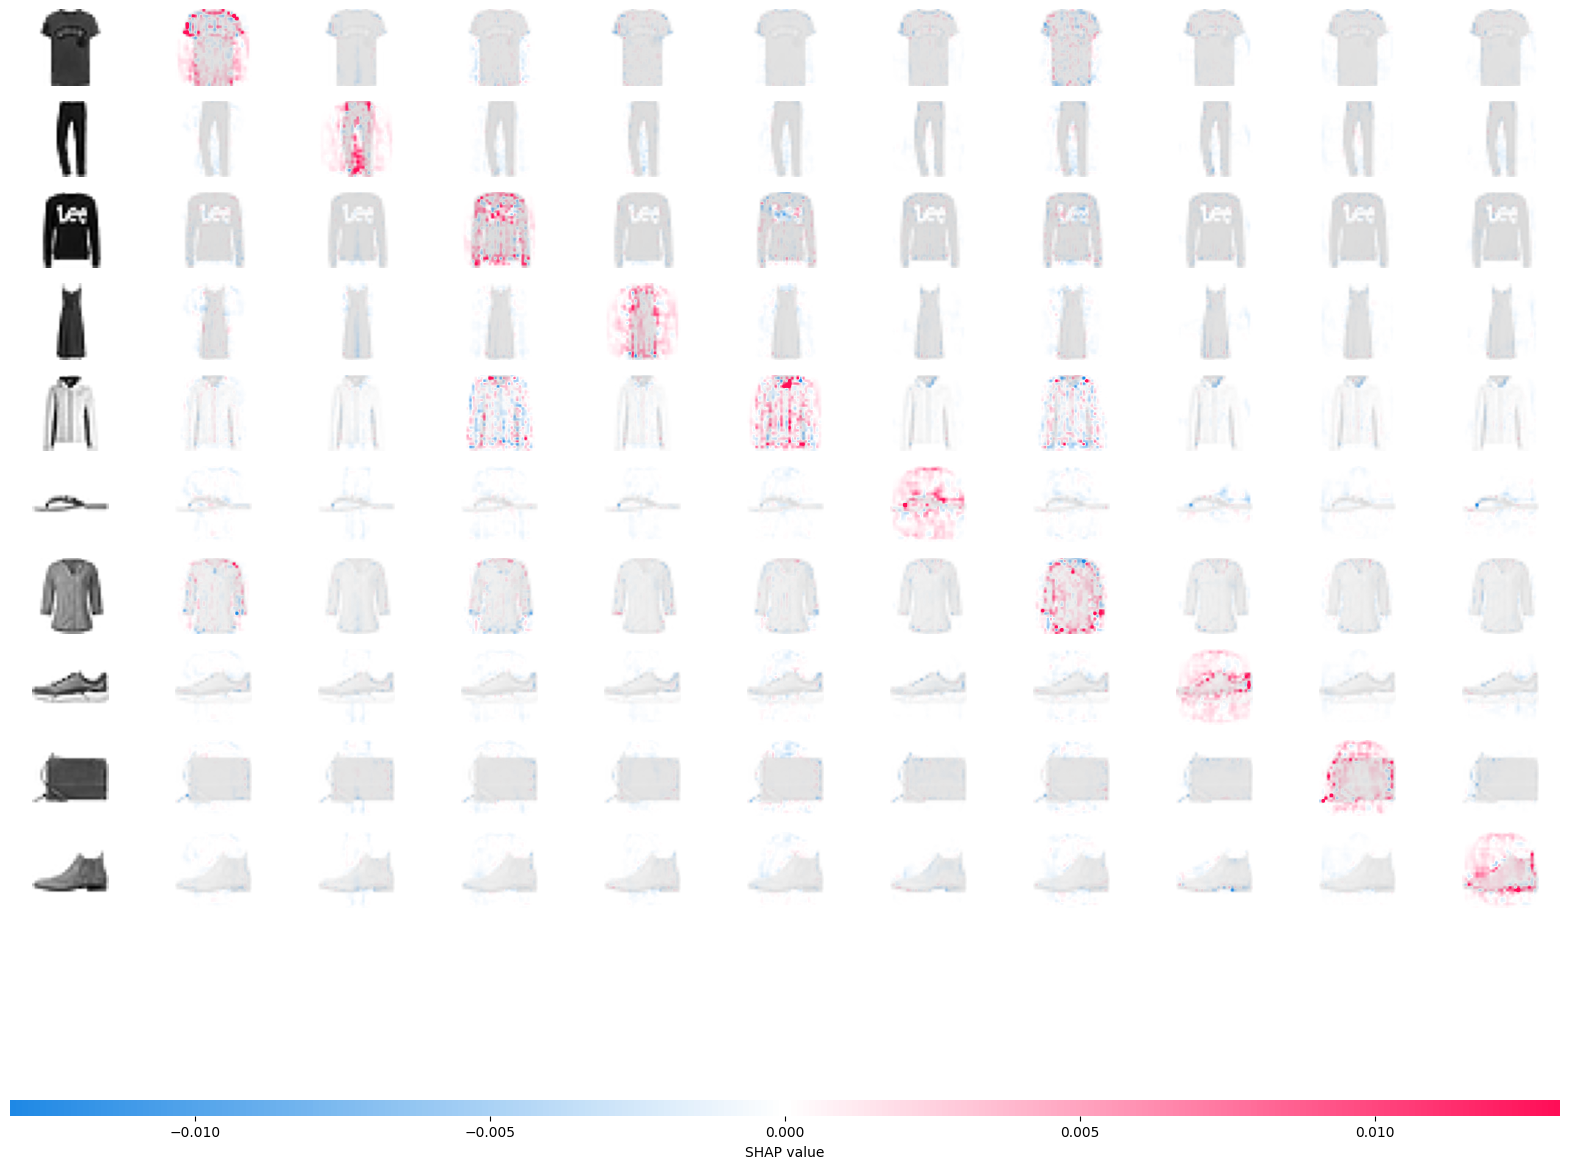

In [13]:
# Plot reference column
plot_categories(images_dict)
# Print an empty line to separate the two plots
print()
# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

Now, give yourself some time to comprehend what the story is trying to convey. It seems reasonable that the shapley values along the diagonal are the most common since the model can successfully categorise each of these 10 images. Particularly favourable values considering that the model (accurately) anticipated that class.

What else is there to infer from this story? Focus on only one instance. Consider the sixth class, the coat, as an example. It appears that the model had additional "reasons" for classifying it as a pullover or shirt. This can be inferred from the fact that certain clases have positive shap values.

To make sure that this was the case, let's look at the tensor of predictions:

In [14]:
# Save the probability of belonging to each class for the fifth element of the set
coat_probs = predictions[4]
# Order the probabilities in ascending order
coat_args = np.argsort(coat_probs)
# Reverse the list and get the top 3 probabilities
top_coat_args = coat_args[::-1][:3]
# Print (ordered) top 3 classes
for i in list(top_coat_args):
  print(class_names[i])


Coat
Pullover
Shirt


You can get a lot of insight repeating this process for all the classes.

#Explainable classifier using XGBoost :  Various plots available in SHAP

##Generate the XGB Classifier:

In [15]:
import pandas as pd
import shap

In [16]:
# import the dataset from Sklearn
from sklearn.datasets import load_breast_cancer
# Read the DataFrame, first using the feature data
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
# Add a target column, and fill it with the target data
df['target'] = data.target
# Show the first five rows
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [17]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [18]:
y = df['target'].to_frame() # define Y
X = df[df.columns.difference(['target'])] # define X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # create train and test
# build model - Xgboost
xgb_mod = XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train,y_train.values.ravel())
# make prediction and check model accuracy
y_pred = xgb_mod.predict(X_test)
# Performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 95.61%


[07:34:39] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
[07:34:39] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.


#2.  Generate the explainer:

In [19]:
# Generate the Tree explainer and SHAP values
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value


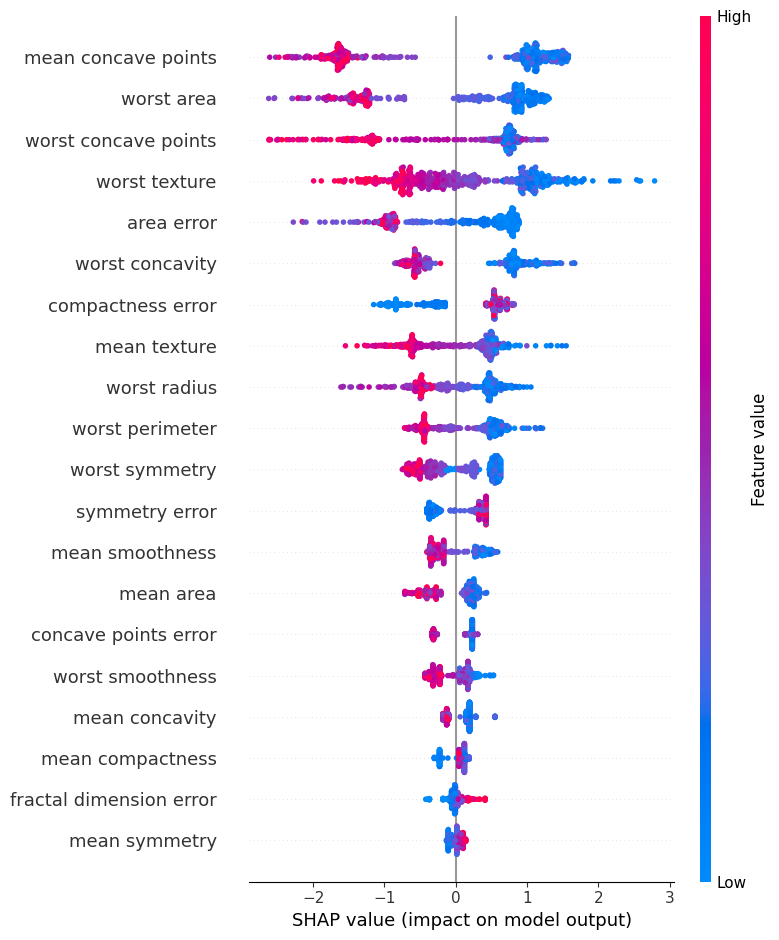

In [20]:
# Generate summary dot plot
shap.summary_plot(shap_values, X,title="SHAP summary plot")


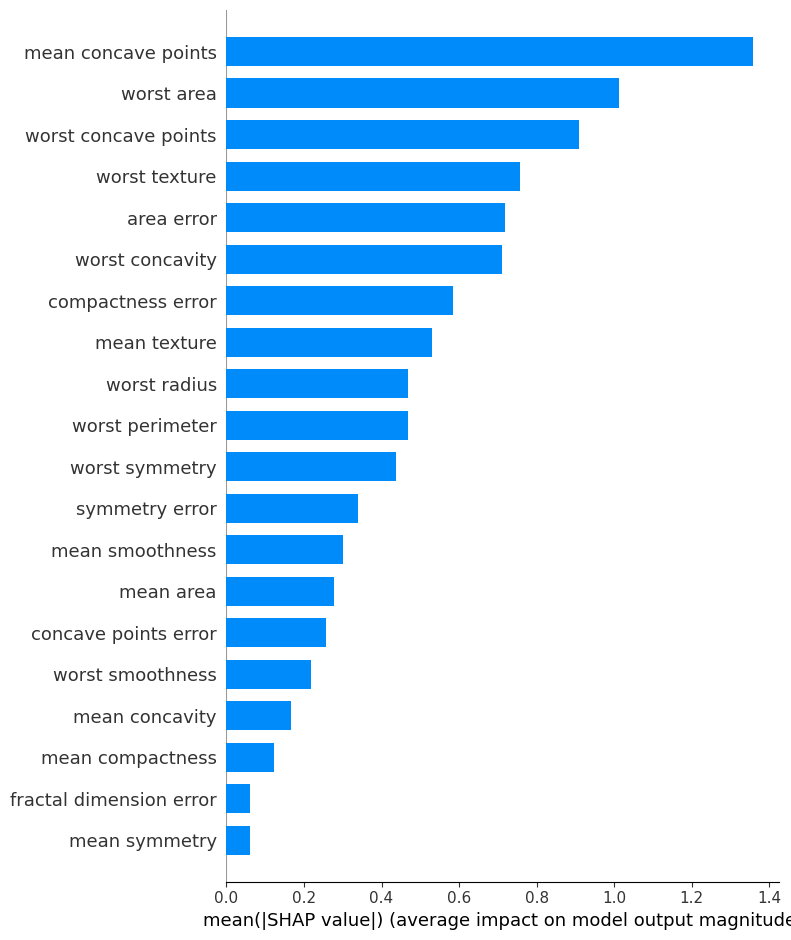

In [21]:
# Generate summary bar plot
shap.summary_plot(shap_values, X,plot_type="bar")


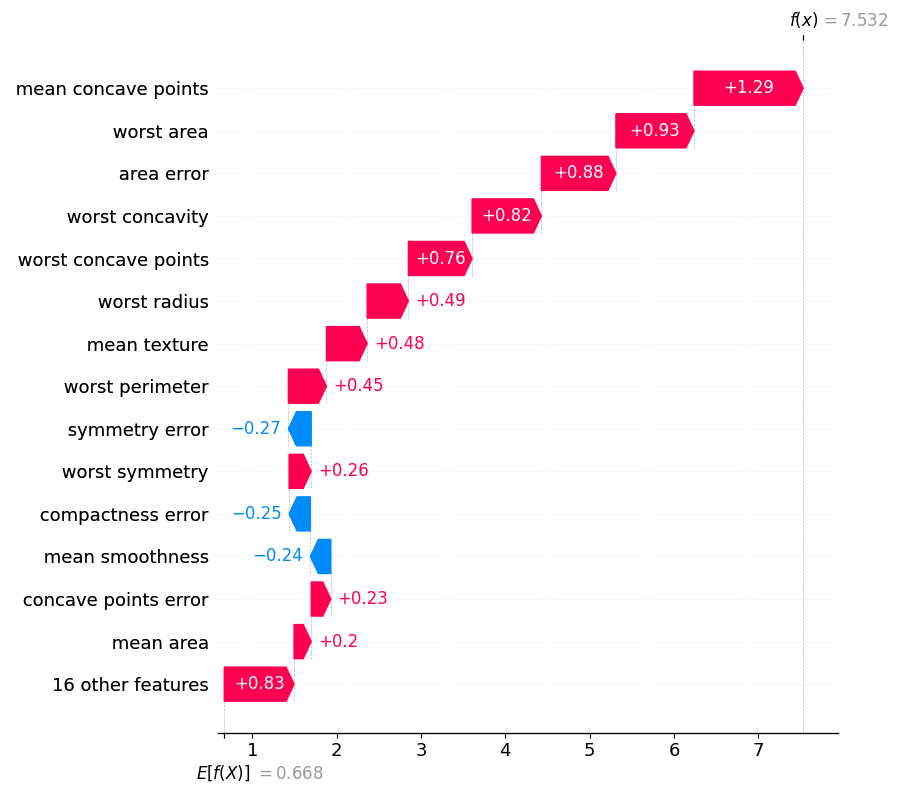

In [22]:
# Generate waterfall plot
shap.plots._waterfall.waterfall_legacy(expected_value,
                                       shap_values[79],
                                       features=X.loc[79,:],
                                       feature_names=X.columns,
                                       max_display=15,
                                       show=True)


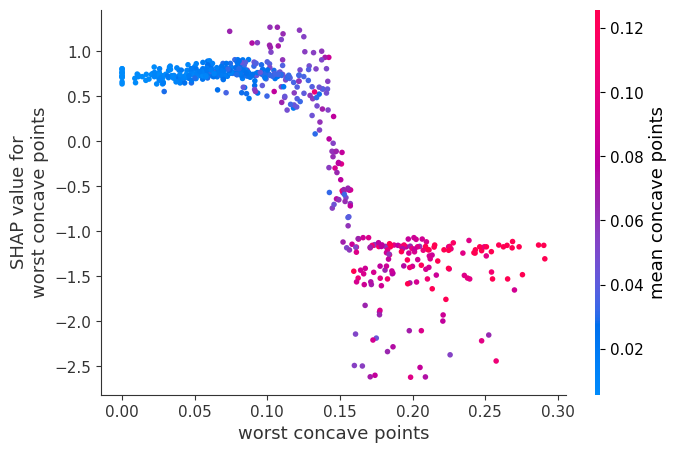

In [23]:
# Generate dependence plot
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")


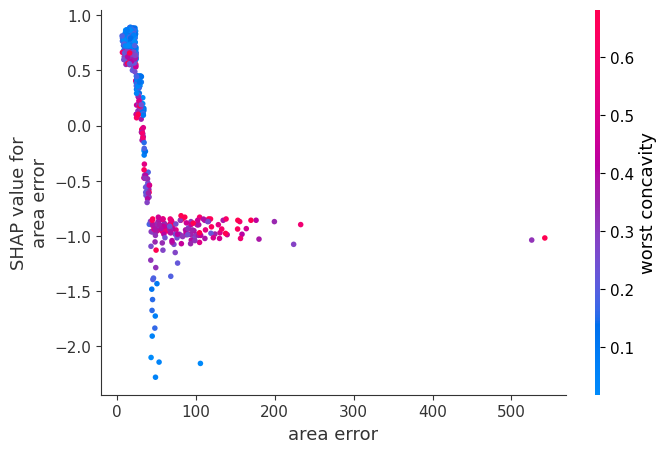

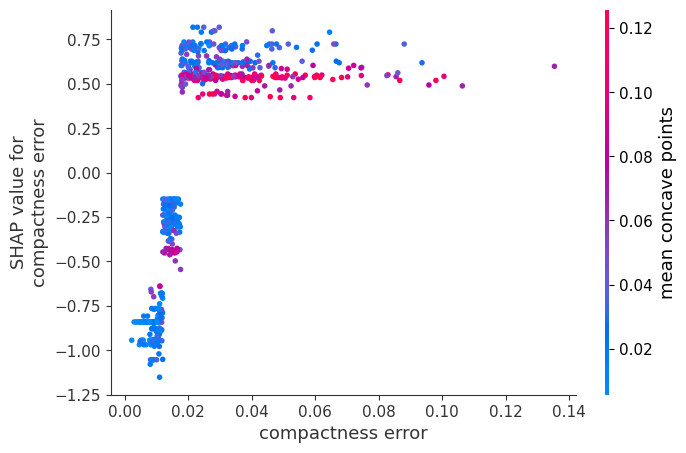

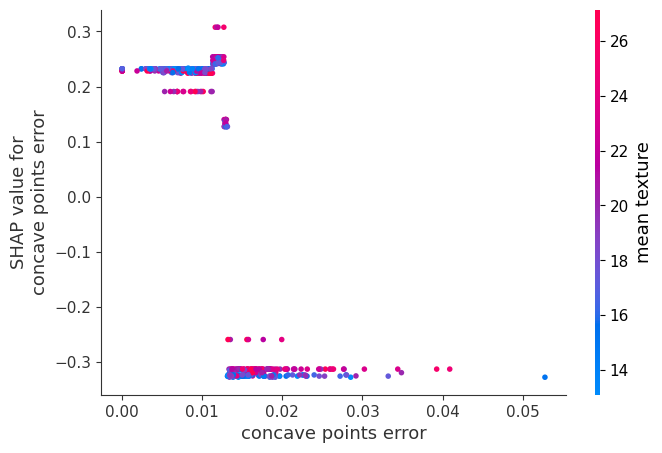

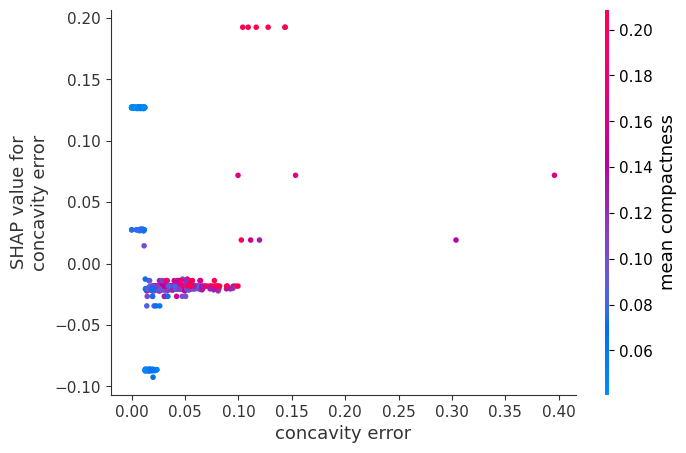

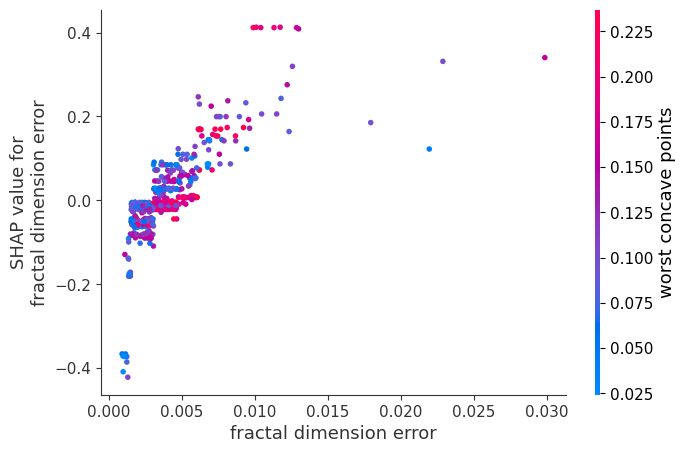

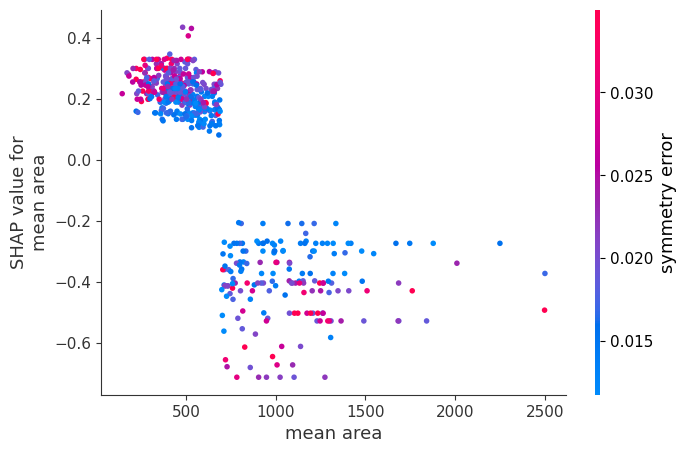

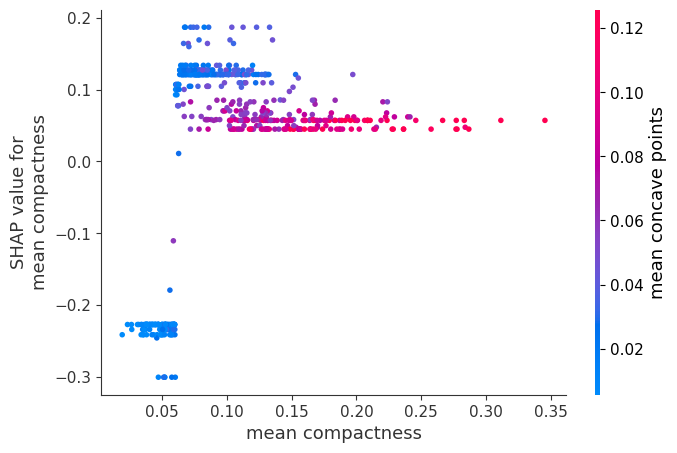

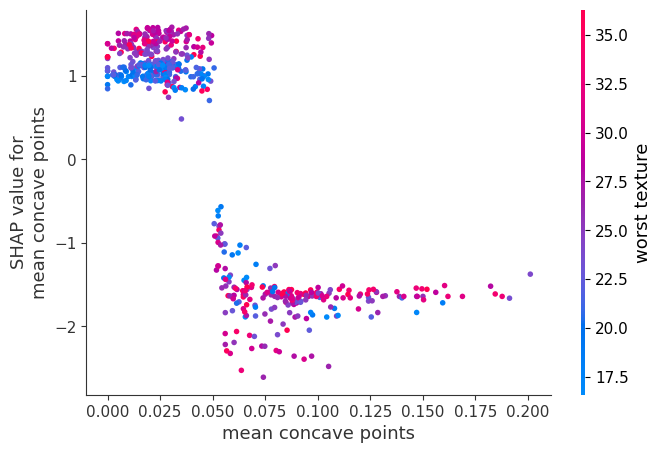

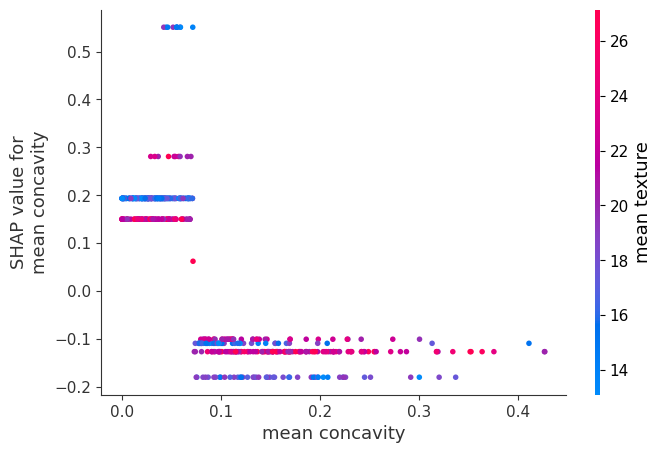

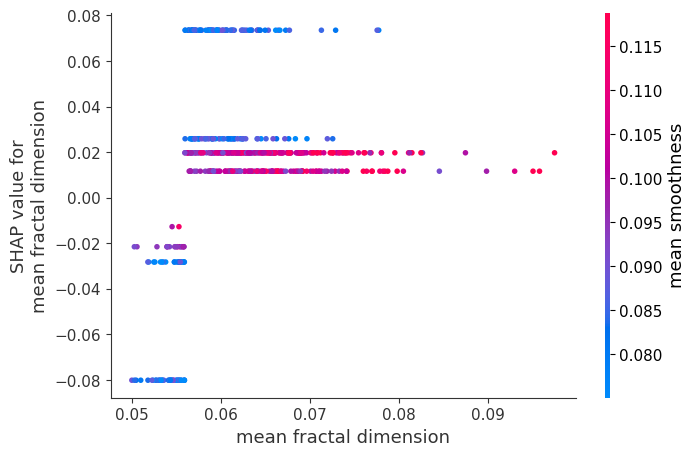

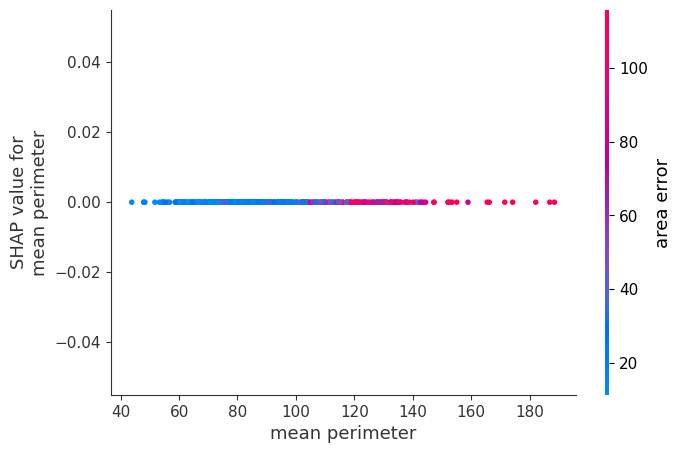

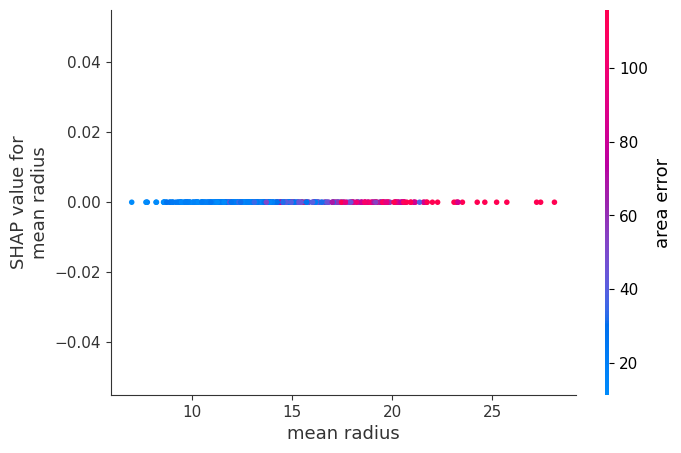

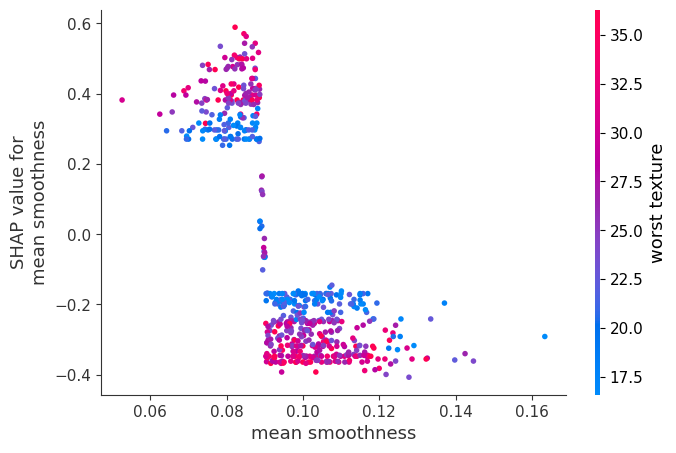

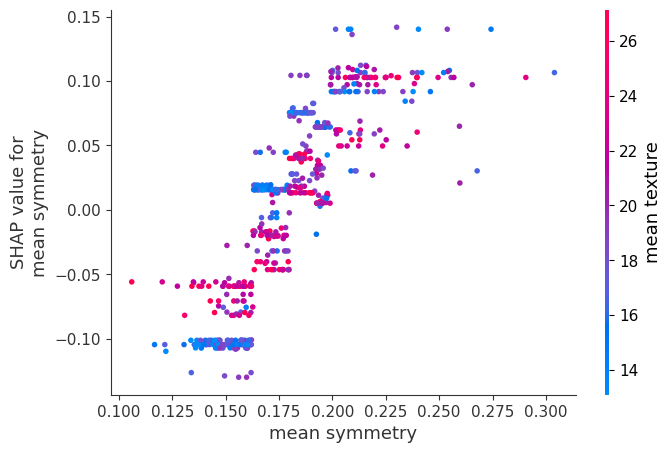

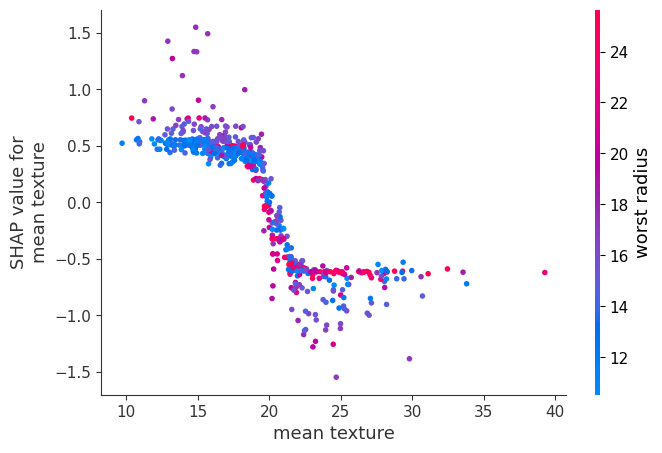

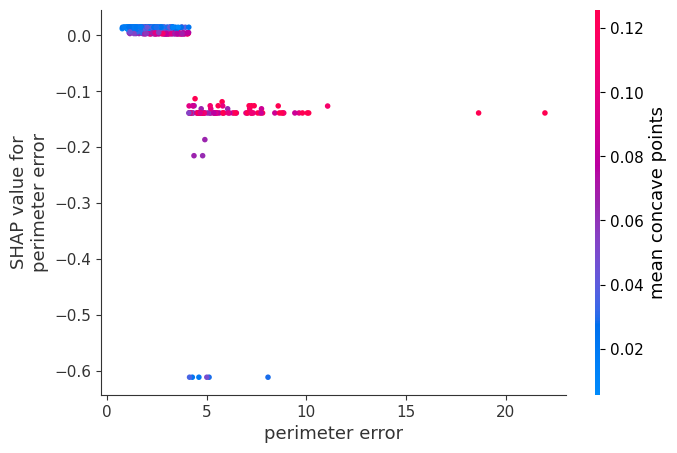

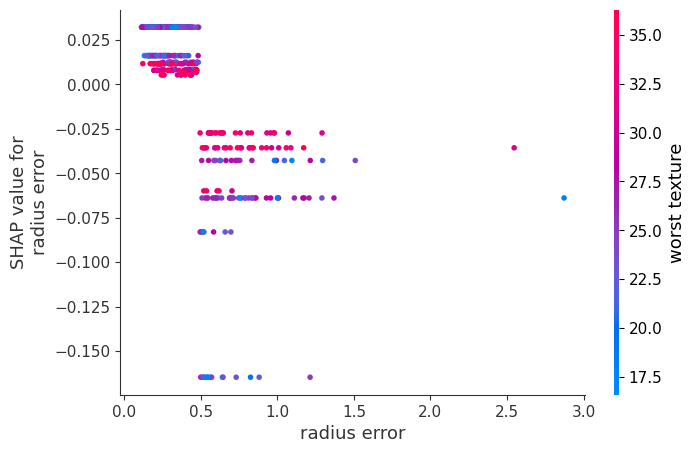

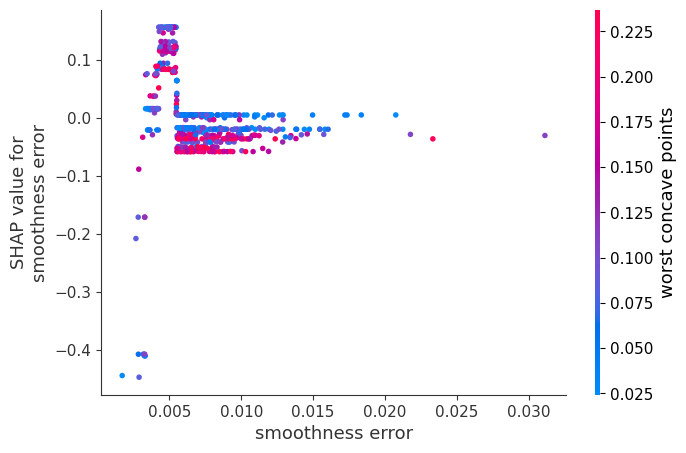

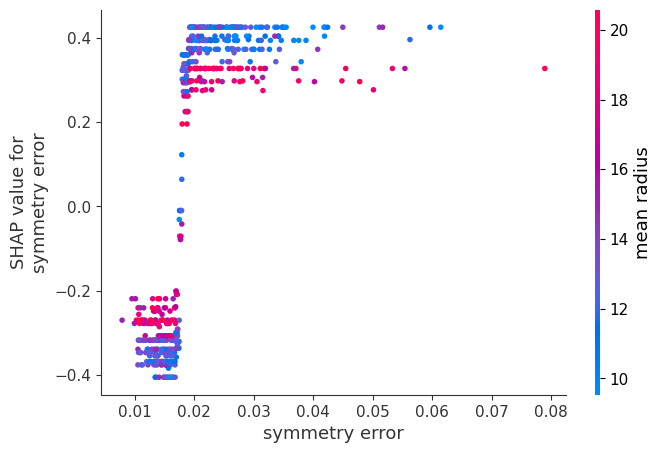

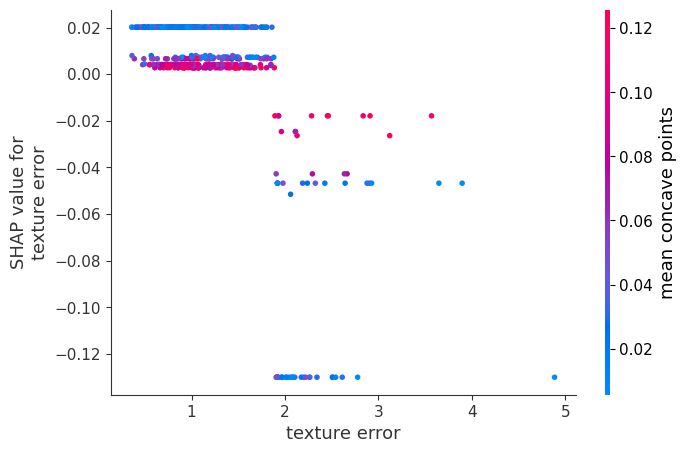

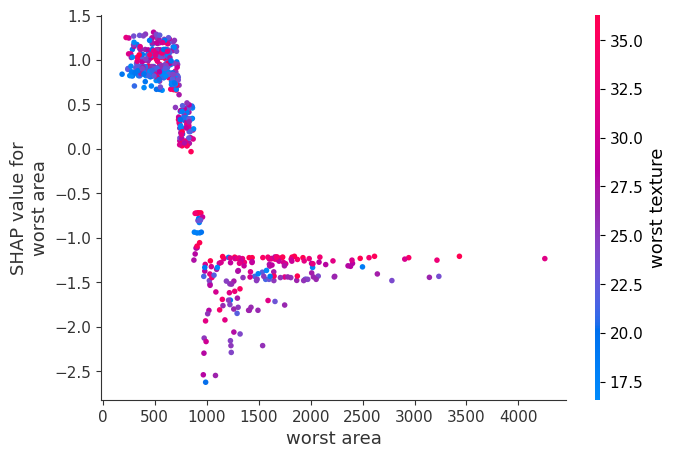

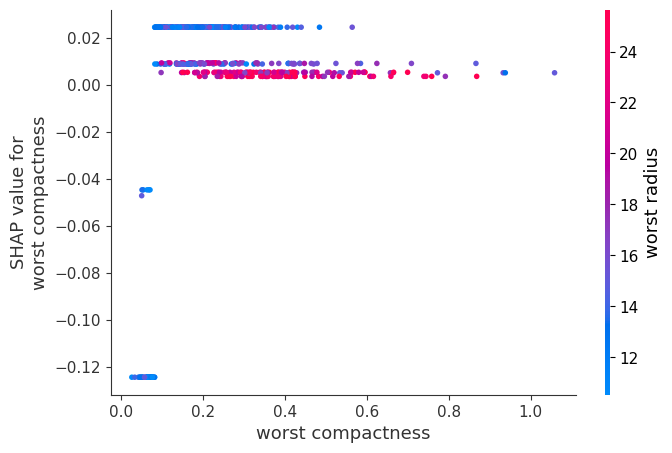

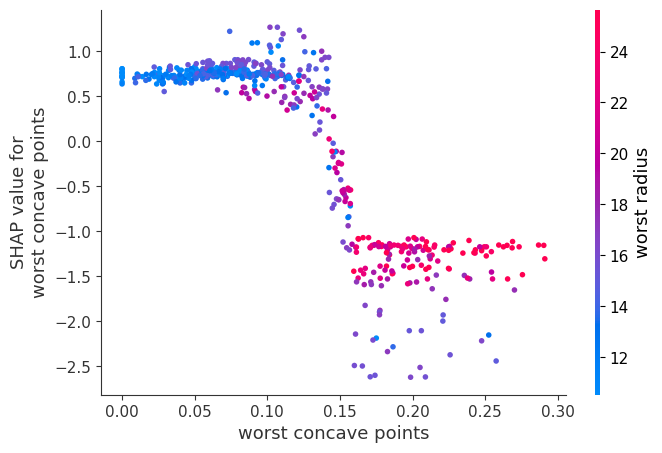

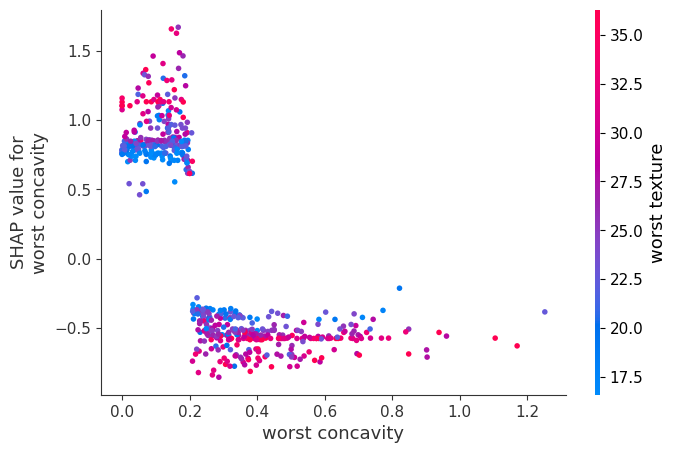

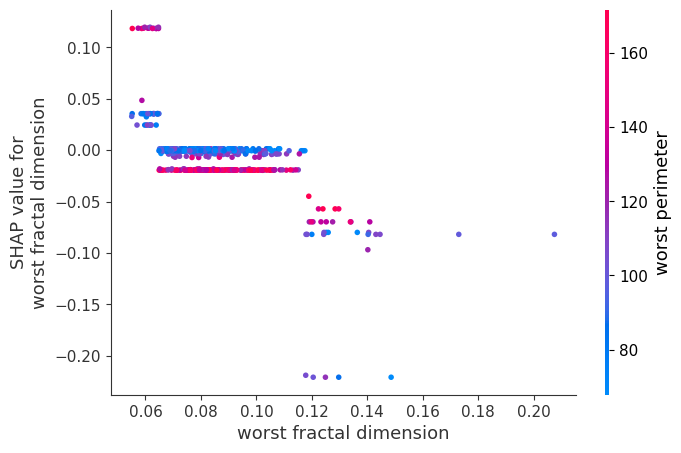

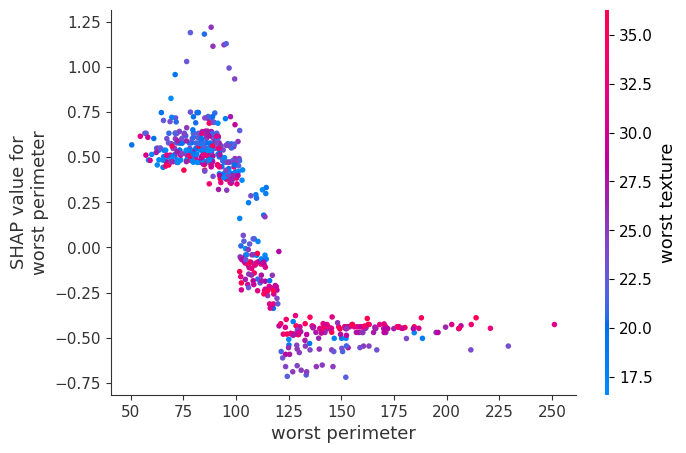

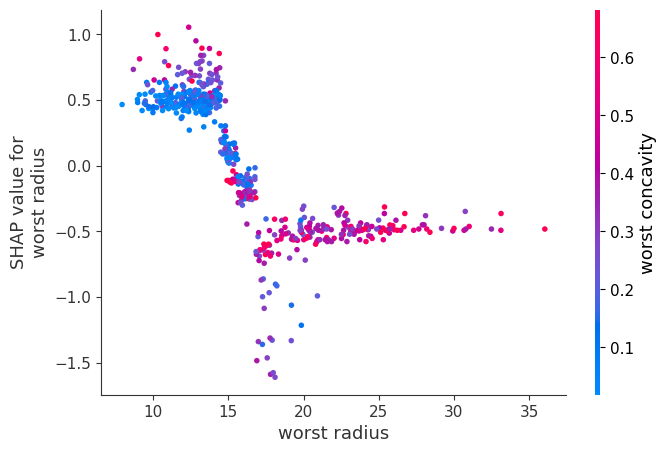

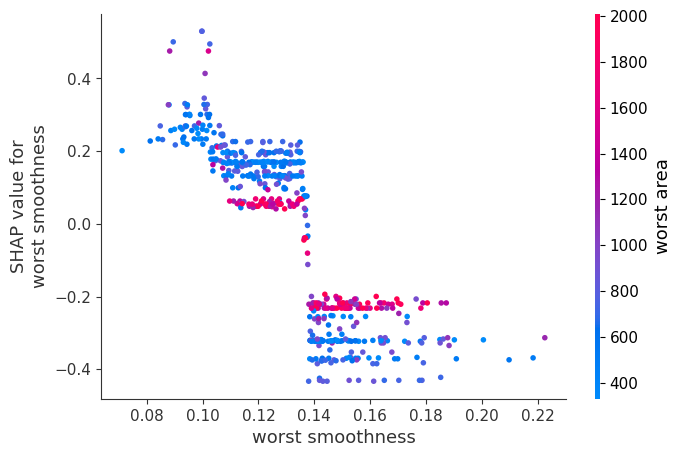

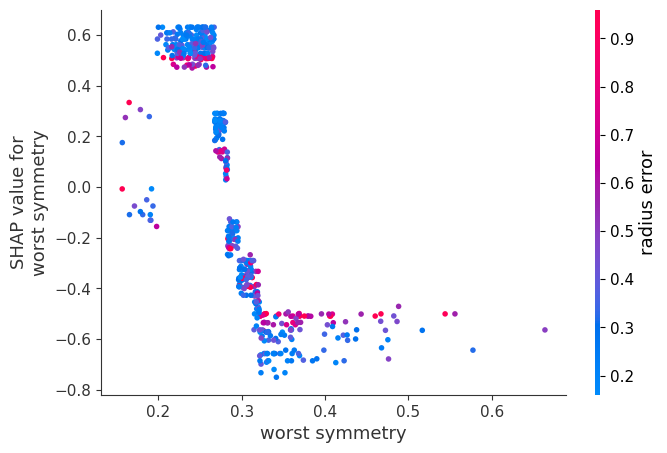

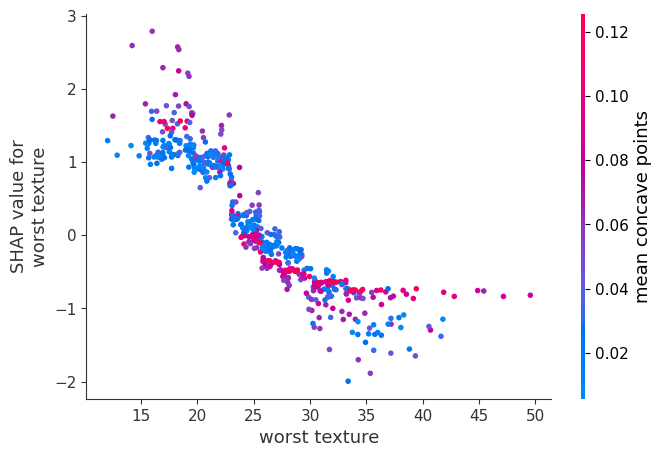

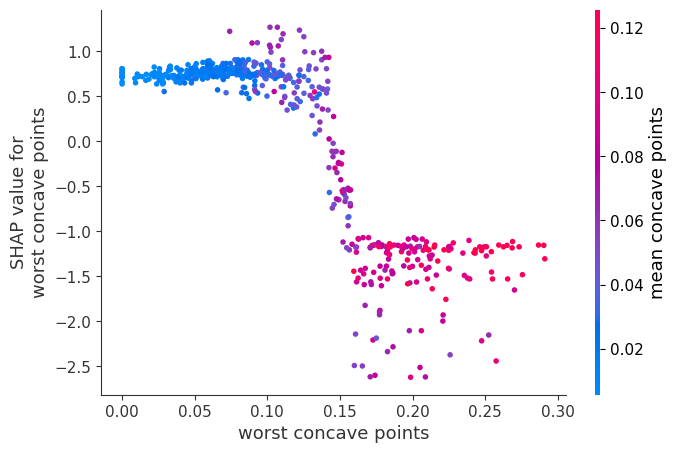

In [24]:
# Generate multiple dependence plots
for name in X_train.columns:
     shap.dependence_plot(name, shap_values, X)
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")


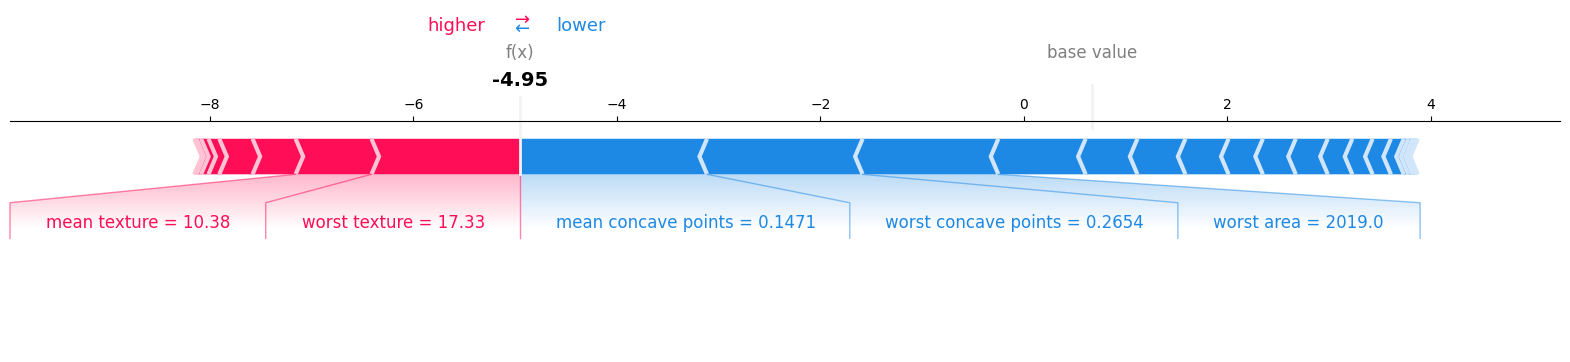

In [25]:
# Generate force plot - Single
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)


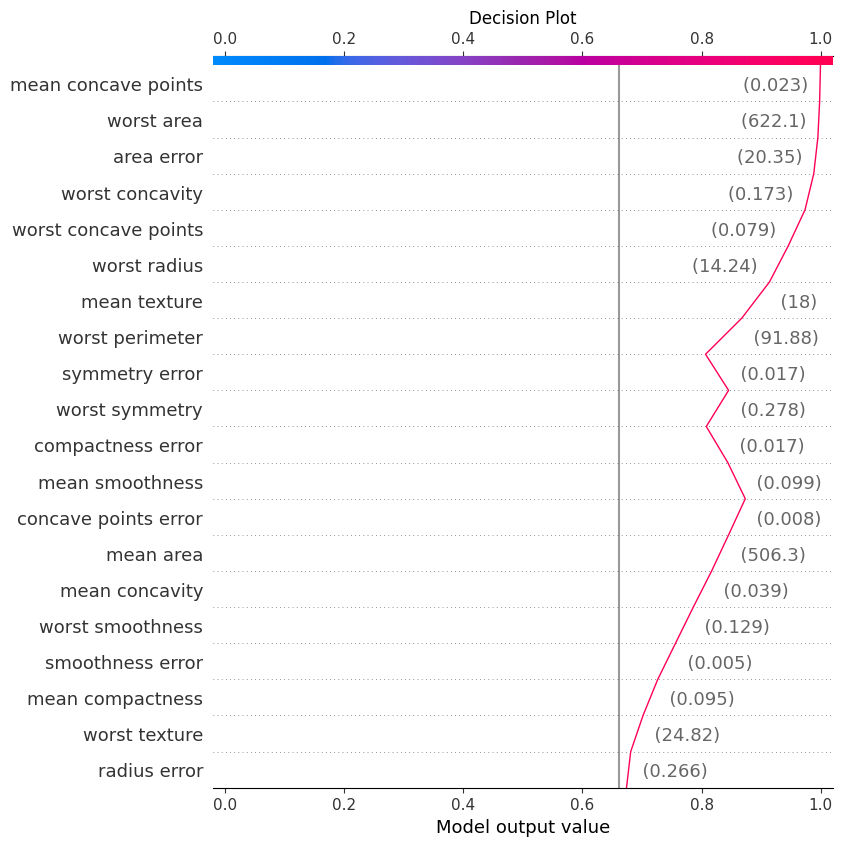

In [26]:
# Generate Decision plot
shap.decision_plot(expected_value, shap_values[79],
                   link='logit' ,features=X.loc[79,:],
                   feature_names=(X.columns.tolist()),
                   show=True,title="Decision Plot")


#<font color='red'>That's All Thanks for visiting....HappY Learning <>